# siim data preprocess  

## 1. review label  


In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from util import mask2rle, rle2mask

In [2]:
# configs

data_path = '../../data/siim-pneumothorax'
train_path = os.path.join(data_path, 'train_png')

anno_filename = 'train-rle.csv'


In [3]:
# read anno

anno_df = pd.read_csv(os.path.join(data_path, anno_filename), sep='\s*,\s*')

anno_df.head(5)


/home/voyager/anaconda3/envs/siim/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


(1024, 1024)


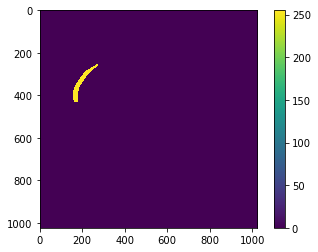

(1024, 1024)


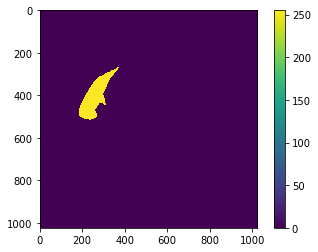

(1024, 1024)


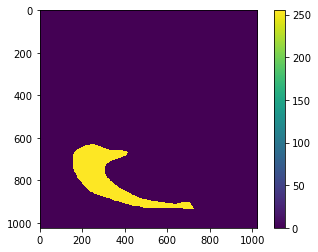

(1024, 1024)


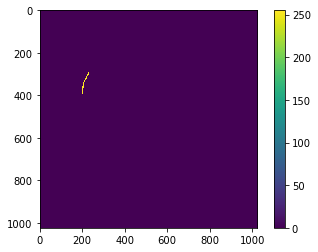

(1024, 1024)


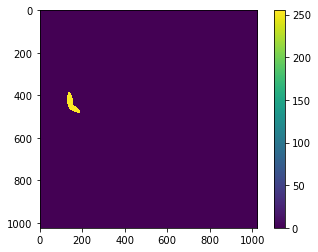

In [4]:
# try to convert and draw mask

mask_df = anno_df[anno_df['EncodedPixels']!='-1']
img_list = os.listdir(train_path)

for i in range(5):
    index = random.randint(0, len(mask_df)-1)

    imageId = mask_df.iloc[index]['ImageId']
    img_filename = os.path.join(train_path, '{}.png'.format(imageId))
    img = Image.open(img_filename)
    w, h = img.size

    mask = rle2mask(mask_df.iloc[index]['EncodedPixels'], w, h)
    print(mask.shape)

    plt.imshow(mask)
    plt.colorbar()
    plt.show()

In [32]:
# unique ids
unique_id_list = np.array(list(set(list(anno_df['ImageId']))))


In [29]:
# merge multi mask in one sample

mask_id_list = list(mask_df['ImageId'])

unique_mask_id_list = list(set(mask_id_list))

print('with dup: {}, without dup: {}'.format(len(mask_id_list), len(unique_mask_id_list)))

# simple check
for mid in mask_id_list:
    if mid not in unique_mask_id_list:
        print('Oops! {}'.format(mid))

mask_path = os.path.join(data_path, 'mask_png')
if not os.path.exists(mask_path):
    os.mkdir(mask_path)
        
# ok, merge
with tqdm(total=len(unique_mask_id_list), file=sys.stdout) as pbar:
    for i, umid in enumerate(unique_mask_id_list):
        # get pic width and height
        img_filename = os.path.join(train_path, '{}.png'.format(umid))
        img = Image.open(img_filename)
        w, h = img.size

        rles = list(mask_df[mask_df['ImageId']==umid]['EncodedPixels'])

        img_mask = np.zeros(w * h)
        img_mask = img_mask.reshape(w, h)

        for rle in rles:
            mask = rle2mask(rle, w, h)
            img_mask = np.maximum(img_mask, mask)

        '''
        if len(rles) > 1:
            plt.imshow(img_mask)
            plt.colorbar()
            plt.show()
        '''

        mask_img = Image.fromarray(img_mask.T).convert('RGB')
        mask_img.save(os.path.join(data_path, 'mask_png/{}.png'.format(umid)), 'PNG')
        
        pbar.update(1)

with tqdm(total=len(unique_id_list), file=sys.stdout) as pbar:
    for uid in unique_id_list:
        if uid not in unique_mask_id_list:
            # get pic width and height
            img_filename = os.path.join(train_path, '{}.png'.format(uid))
            img = Image.open(img_filename)
            w, h = img.size

            img_mask = np.zeros(w * h)
            img_mask = img_mask.reshape(w, h)

            mask_img = Image.fromarray(img_mask).convert('RGB')
            mask_img.save(os.path.join(data_path, 'mask_png/{}.png'.format(uid)), 'PNG')
            
        pbar.update(1)

with dup: 3286, without dup: 2379
  0%|          | 0/2379 [00:00<?, ?it/s]


AttributeError: type object 'Image' has no attribute 'open'

In [30]:
# check train and mask

train_file_list = os.listdir(train_path)
mask_file_list = os.listdir(os.path.join(data_path, 'mask_png'))

for train_file in train_file_list:
    if train_file not in mask_file_list:
        print('extra train_file: {}'.format(train_file))
        
for mask_file in mask_file_list:
    if mask_file not in train_file_list:
        print('extra mask_file: {}'.format(mask_file))
        

extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4843.1517875185.73985.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.31801.1517875156.929061.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.32688.1517875161.809571.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4373.1517875182.554858.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.32302.1517875159.778024.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.3714.1517875179.128897.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.2083.1517875171.71387.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.5543.1517875188.726955.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.5087.1517875186.354925.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4134.1517875181.277174

In [37]:
# pick val set

from sklearn.model_selection import StratifiedKFold

# config
FOLD = 5
TAG = 'SIIM_{}-FOLD'.format(FOLD)

# helper
def write_csv(tag, path, phase, index, samples):
    sub_dir = os.path.join(path, '{}'.format(tag))
    
    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)
        
    filename = os.path.join(sub_dir, '{}-{}.csv'.format(phase, index))
    print('Exporting to {}...'.format(filename))
    
    with open(filename, 'w') as file:
        
        for sample in samples:
            if phase == 'val':
                file.write('{}.png\n'.format(sample))
            else:
                file.write('train_png/{}.png\n'.format(sample))
            
# main
target_list = np.array([0 if mid not in unique_mask_id_list else 1 for mid in unique_id_list])

k_fold = StratifiedKFold(n_splits=FOLD, shuffle=True)

i = 0

for train_ids, val_ids in k_fold.split(unique_id_list, target_list):
    write_csv(TAG, data_path, 'train', i, [unique_id_list[index] for index in train_ids])
    write_csv(TAG, data_path, 'val', i, [unique_id_list[index] for index in val_ids])
    
    i += 1
    
write_csv(TAG, data_path, 'all', 0, unique_id_list)


Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/all-0.csv...


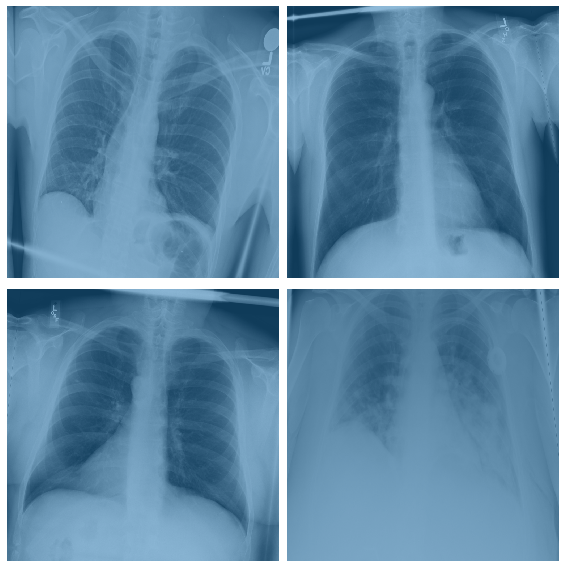

In [39]:
# let's try to use fastai to load them

import fastai
from fastai.vision import *

path = Path(data_path)

# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
    
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

# Create databunch
data = (SegmentationItemList.from_csv(path=path, csv_name='SIIM_5-FOLD/all-0.csv')
        .split_by_fname_file('SIIM_5-FOLD/val-0.csv')
        .label_from_func(lambda x : str(x).replace('train_png', 'mask_png'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=1024, tfm_y=True)
        .databunch(path=Path('.'), bs=4)
        .normalize(imagenet_stats))

data.show_batch()

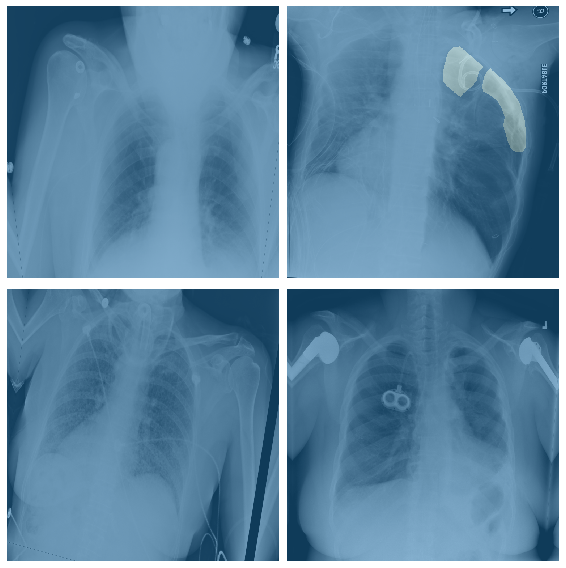

In [42]:
data.show_batch()